# Introduction

* Time series volatility models, such as GARCH (Generalized Autoregressive Conditional Heteroskedasticity) and ARCH (Autoregressive Conditional Heteroskedasticity) models, work by estimating the conditional variance of a financial time series.

* The basic idea behind these models is that volatility tends to cluster together in time, meaning that periods of high volatility are likely to be followed by periods of high volatility, and periods of low volatility are likely to be followed by periods of low volatility. By modeling the conditional variance of the time series, these models attempt to capture these volatility patterns.

* Recent literature has shown that if we combine ml model with GARCH models we can attain better accuracy for variance.

* in this notebook we will use Support vectoe regression with Garch to forcast volatilty 

* We use the parcentage change in returns and realised volatility as the independent varriables and we use the variance forecast from the Garch model for our predictions

In [148]:
import numpy as np
from scipy.stats import norm
import scipy.optimize as opt
import yfinance as yf
import pandas as pd
import datetime
import time
from arch import arch_model
import matplotlib.pyplot as plt
import plotly.express as px
pd.options.plotting.backend = "plotly"
pd.set_option('display.max_columns', 150, 'display.max_rows', 100, 'display.max_colwidth', 15)
%matplotlib inline
from numba import jit
from sklearn.metrics import mean_squared_error as mse
import warnings
warnings.filterwarnings('ignore')
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 100

## Load Data for stocks
for S&P 500 stocks from 01-01-2010 to 01-08-2021

In [149]:
stocks = '^GSPC'
start = datetime.datetime(2010, 1, 1)
end = datetime.datetime(2021, 8, 1)
s_p500 = yf.download(stocks, start=start, end = end, interval='1d')
s_p500.index= pd.to_datetime(s_p500.index, format= "%Y-%m-%d").date
s_p500.index

[*********************100%***********************]  1 of 1 completed


Index([2010-01-04, 2010-01-05, 2010-01-06, 2010-01-07, 2010-01-08, 2010-01-11,
       2010-01-12, 2010-01-13, 2010-01-14, 2010-01-15,
       ...
       2021-07-19, 2021-07-20, 2021-07-21, 2021-07-22, 2021-07-23, 2021-07-26,
       2021-07-27, 2021-07-28, 2021-07-29, 2021-07-30],
      dtype='object', length=2914)

In [150]:
s_p500.index.names = ['Date']

In [151]:
s_p500

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-04,1116.560059,1133.869995,1116.560059,1132.989990,1132.989990,3991400000
2010-01-05,1132.660034,1136.630005,1129.660034,1136.520020,1136.520020,2491020000
2010-01-06,1135.709961,1139.189941,1133.949951,1137.140015,1137.140015,4972660000
2010-01-07,1136.270020,1142.459961,1131.319946,1141.689941,1141.689941,5270680000
2010-01-08,1140.520020,1145.390015,1136.219971,1144.979980,1144.979980,4389590000
...,...,...,...,...,...,...
2021-07-26,4409.580078,4422.729980,4405.450195,4422.299805,4422.299805,4275630000
2021-07-27,4416.379883,4416.379883,4372.509766,4401.459961,4401.459961,4241950000
2021-07-28,4402.950195,4415.470215,4387.009766,4400.640137,4400.640137,4215290000


In [152]:
s_p500.isna().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

## rename all columns to lower letters and remove spaces

In [153]:
s_p500.columns =  [x.lower().replace(" ", "") for x in s_p500.columns]
s_p500

,open,high,low,close,adjclose,volume
Date,,,,,,
2010-01-04,1116.560059,1133.869995,1116.560059,1132.989990,1132.989990,3991400000
2010-01-05,1132.660034,1136.630005,1129.660034,1136.520020,1136.520020,2491020000
2010-01-06,1135.709961,1139.189941,1133.949951,1137.140015,1137.140015,4972660000
2010-01-07,1136.270020,1142.459961,1131.319946,1141.689941,1141.689941,5270680000
2010-01-08,1140.520020,1145.390015,1136.219971,1144.979980,1144.979980,4389590000
...,...,...,...,...,...,...
2021-07-26,4409.580078,4422.729980,4405.450195,4422.299805,4422.299805,4275630000
2021-07-27,4416.379883,4416.379883,4372.509766,4401.459961,4401.459961,4241950000
2021-07-28,4402.950195,4415.470215,4387.009766,4400.640137,4400.640137,4215290000


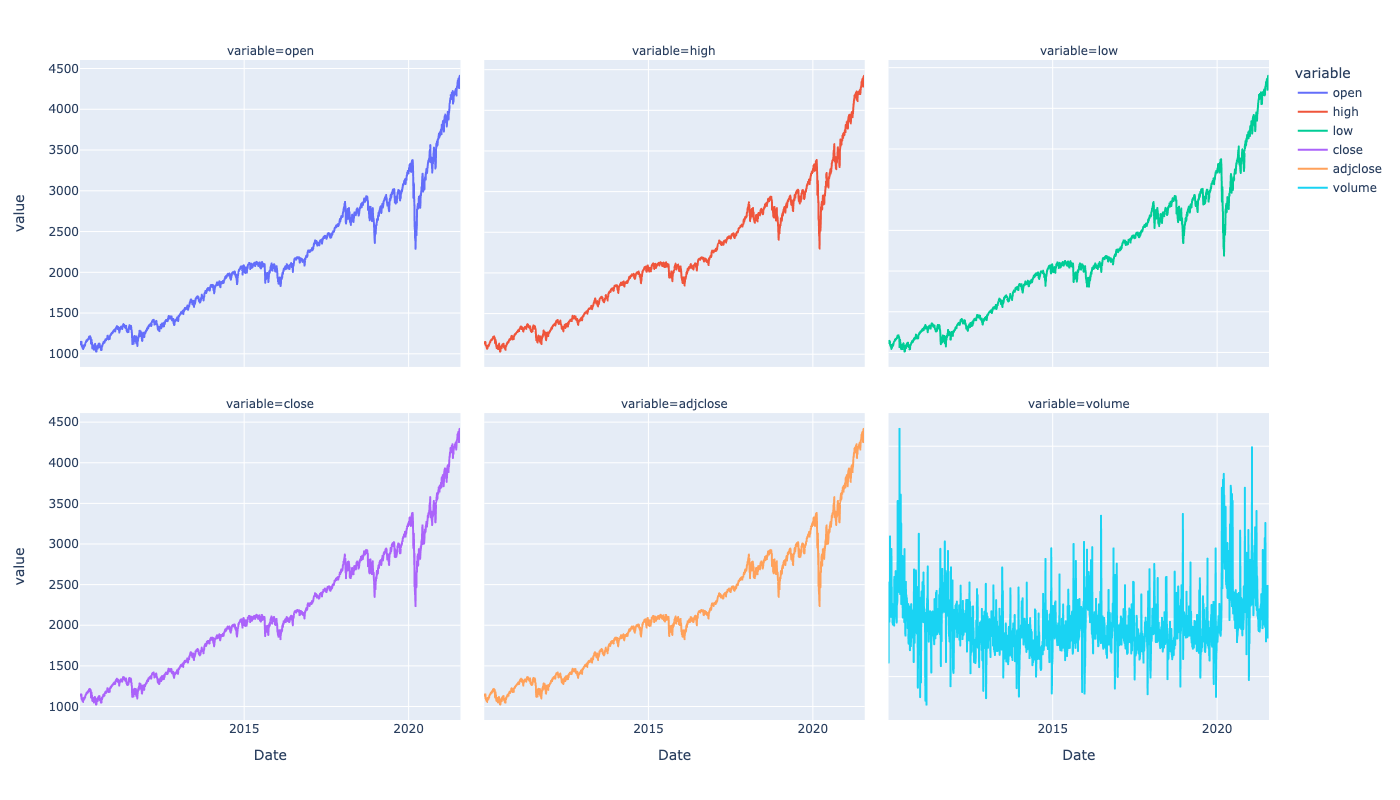

In [154]:
(
    s_p500
    .reset_index()
    .melt(id_vars= "Date")
    .plot.line(
    x= "Date" ,y= "value",
    facet_col= "variable",
    facet_col_wrap= 3, 
    color= "variable", 
    height= 800, width= 1400)
    .update_yaxes(matches=None) 
       
    ).show("png")

Take percentage change, which is the change in value today compared to yesterday. 

We can change the number to 2, 3, 4 if we want to take percentage change comapred to more than one day ago

## Calculate returns based on adjclose price

we take percentage change from previous value compared to todays values as returns (ret)

difference between yesterday and todays values will be gains or losses.


In [155]:
ret = s_p500.assign(returns=100 * (s_p500.pct_change()[['adjclose']]))[["returns"]].iloc[1:]
ret

,returns
Date,
2010-01-05,0.311568
2010-01-06,0.054552
2010-01-07,0.400120
2010-01-08,0.288173
2010-01-11,0.174676
...,...
2021-07-26,0.238220
2021-07-27,-0.471244
2021-07-28,-0.018626


To gauge the extent to which proposed models account for the real-world situation, we need to calculate the return volatility, which is also known as realized volatility.

Realized volatility is the square root of realized variance (standard deviation), which is the sum of squared returns.

Realized volatility is used to calculate the performance of the volatility prediction method. Here is the formula for return volatility:

$$\sigma = \sqrt{\frac{1}{n-1} \sum_{n=1}^{N} (r_n - \mu)^2}$$

where $\sigma$ is the return volatility, $n$ is the number of returns, $N$ is the total number of returns, $r_n$ is the return at time $n$, and $\mu$ is the mean return.

By using this formula, we can measure the volatility of returns over a given period, and use it to compare the performance of different volatility models.

We calculate volatility over the period of 5, as rolling std deviation of 5 window.

## Create Realized Volatility

In [156]:
ret= ret.assign(
    realized_vol= ret.returns.rolling(5).std(),
                ).dropna()
ret.head()

,returns,realized_vol
Date,,
2010-01-11,0.174676,0.133763
2010-01-12,-0.938117,0.537728
2010-01-13,0.832593,0.658062
2010-01-14,0.242643,0.646860
2010-01-15,-1.082313,0.823912


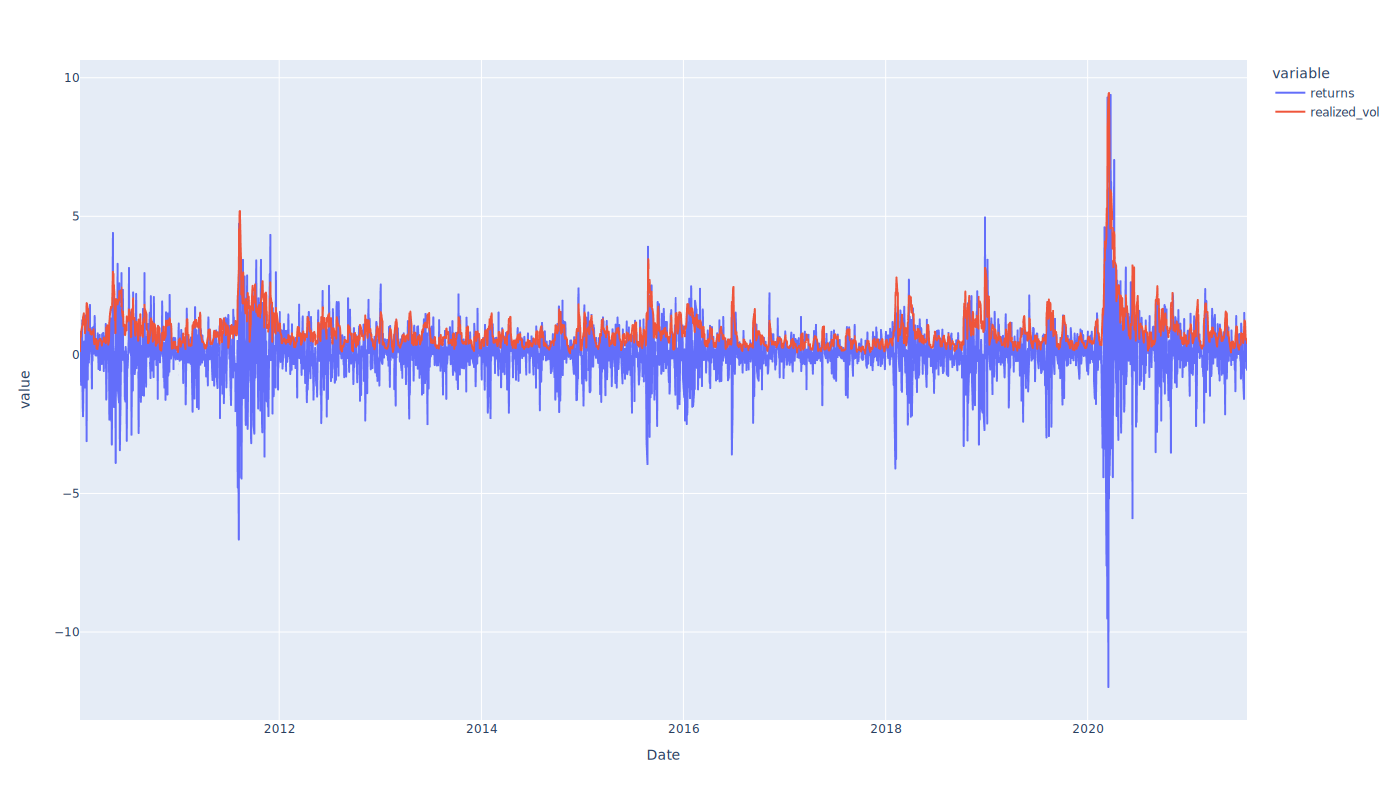

In [157]:
(
    ret
    # .reset_index()
    # .melt(id_vars = "Date")
    .plot(
    # x= "Date", y= "value", 
    # facet_row = "variable", color="variable" ,
    height= 800,
    width= 1400
    )
).show("svg")

## ACF PACF plots
 Our series is an MA(1) process and AR(1) process as autocorrelation plot shows not significance lag after 1 and and same for pacf plot

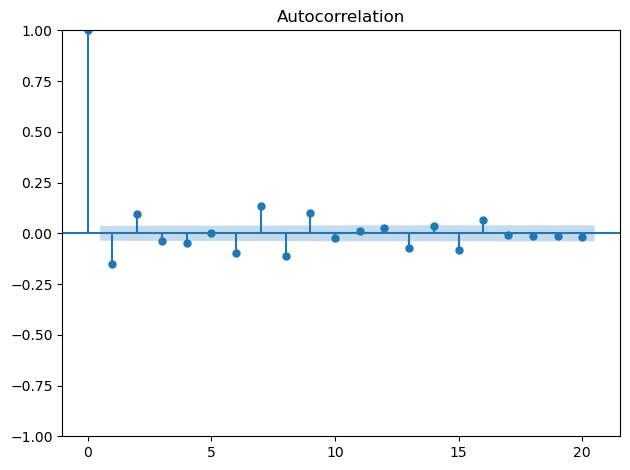

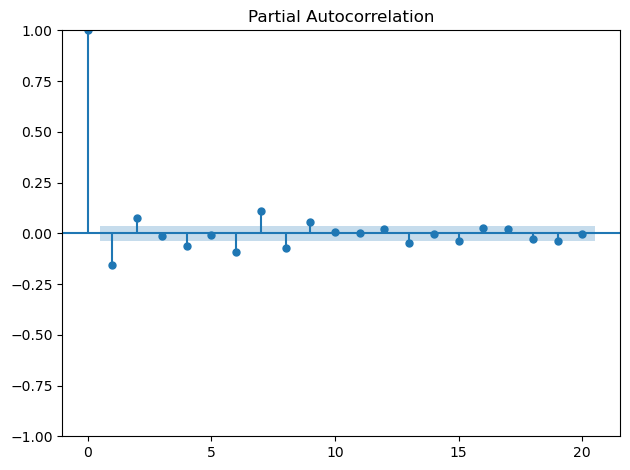

In [158]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(ret.returns , lags=20)
plt.tight_layout()
plot_pacf(ret.returns, lags=20)
plt.tight_layout()

In [159]:
n = 252
split_date = ret.iloc[-n:].index
split_date

Index([2020-07-31, 2020-08-03, 2020-08-04, 2020-08-05, 2020-08-06, 2020-08-07,
       2020-08-10, 2020-08-11, 2020-08-12, 2020-08-13,
       ...
       2021-07-19, 2021-07-20, 2021-07-21, 2021-07-22, 2021-07-23, 2021-07-26,
       2021-07-27, 2021-07-28, 2021-07-29, 2021-07-30],
      dtype='object', name='Date', length=252)

## Data Split
We we forecast volattility for 252 days in the future and seperate the train and test set accordingly

In [160]:
n = 252
split_date = ret.iloc[-n:].index
split_date[0]

datetime.date(2020, 7, 31)

In [161]:
X_train= ret.iloc[:-n]
X_train

,returns,realized_vol
Date,,
2010-01-11,0.174676,0.133763
2010-01-12,-0.938117,0.537728
2010-01-13,0.832593,0.658062
2010-01-14,0.242643,0.646860
2010-01-15,-1.082313,0.823912
...,...,...
2020-07-24,-0.619040,0.859057
2020-07-27,0.739514,0.833538
2020-07-28,-0.647339,0.853929


In [162]:
y_test= ret.realized_vol.iloc[-n:]
y_test

Date
2020-07-31    0.812874
2020-08-03    0.810331
2020-08-04    0.601344
2020-08-05    0.472892
2020-08-06    0.157376
                ...   
2021-07-26    0.553360
2021-07-27    0.586249
2021-07-28    0.539227
2021-07-29    0.548919
2021-07-30    0.424475
Name: realized_vol, Length: 252, dtype: float64

# Def Functions

## Evaluation Function

In [163]:
def eval_rmse(x,y):
    result = np.sqrt(mse(x/100, np.sqrt(y/100)))
    return result

## Plot Function

In [164]:
def plot_forecat(x):
    p=( ret.reset_index()[ret.reset_index().Date > pd.to_datetime('2017-01-01') ]
        .plot.line(x="Date", y= "realized_vol", title= x +' Realized Volatility',color_discrete_sequence=['blue'],width=1200, height= 600)    
        .add_scatter(x=frcts_values.index, y = frcts_values["value"],mode="lines",line=dict(width= 2, color="red"),name= "forecast")    
    )
    return p.show("png")

## Rolling Forecast Function
* In real world scenario we need only 1-2 days of valatility forecast. the function below creates a rolling volatility forecast for one step at a time and produces 
252 models and forecats for each type of model.
* We can also create a forecast directly for next 252 days but it will not be very accurate and it will be based on the coefficents uptill the last point.

In [165]:
def rolling_forecast(y_test,vol, p=0, q=0, o=0 ):
    rolling_predictions = []
    dates=[]
    for i in range(y_test.shape[0]):
        train = ret.returns[:-(y_test.shape[0] -i)]    
        if vol == "None":
            model = arch_model(train, mean='zero', p=p, q=q, o=o)
        else:
            model = arch_model(train, mean='zero', vol= vol, p=p, q=q, o=0)
        model_fit = model.fit(disp='off')
        pred = model_fit.forecast(horizon=1)
        dates.append(train.index[-1])
        rolling_predictions.append(
            #np.sqrt(
            pred.variance.values[-1,:][0]
            #)
            )
    frcts_values= pd.DataFrame(rolling_predictions, columns= ["value"], index= dates)
    return frcts_values
 


## Autoregressive conditional hetroskadestic model (ARCH Model)
Consider the following econometric model:

$Y_t = \rho Y_{t-1} +\beta X + \epsilon_t \qquad\qquad\qquad(1)$

Here, $Y_t$ is the dependent variable at time $t$, $Y_{t-1}$ is the dependent variable at time $t-1$, $X$ is the independent variable, $\beta$ is the coefficient of the independent variable,
and $\epsilon_t$ is the disturbance term (error or residuals) . It is usually assumed that the variance of the disturbance term, denoted as $\sigma^2$, is constant over time.
However, it is possible to allow the variance of the disturbance term to change over time. 
Engle proposed modeling the conditional disturbance variance as an autoregressive conditional heteroscedasticity (ARCH) process of order $p$:

$\sigma_t^2 = \alpha_0 + \alpha_1\epsilon_{t-1}^2 + \dots + \alpha_p\epsilon_{t-p}^2 \qquad\qquad\qquad(2)$

The lagged $\epsilon^2$ terms are called ARCH terms, and the model shown in Equation (2) is known as an ARCH(p) model. 

The conditional disturbance variance is the variance of $\epsilon_t$ conditional on information available at time $t-1$, i.e.,

Variance = $\frac{1}{n} \sum_{i=1}^n (\epsilon_i - \mu)^2$ and 

standard deviation =  $\sqrt{\frac{1}{n} \sum_{i=1}^n (\epsilon_i - \mu)^2}$

$\sigma_t^2 = \mathrm{var}(\epsilon_t|\epsilon_{t-1},\ldots,\epsilon_{t-p}) $

can be read as "the conditional variance of the error term at time t is equal to the conditional variance of ε_t given the past p error terms, ε_t-1 to ε_t-p".

$ = \mathrm{E}(\epsilon_{t}^2|\epsilon_{t-1}^2,\ldots,\epsilon_{t-p}^2) $

can be read as "the conditional variance of the error term at time t is equal to the conditional expectation of ε_t squared, given the past p-1 error terms, ε_t-1^2 to ε_t-p-1^2". This equation is often used to estimate the parameters of the GARCH model.

$ = (\epsilon{t}^2) \mathrm{E}{t-1} \qquad\qquad\qquad(3)$

can be read as "the conditional variance of the error term at time t is equal to the conditional expectation of ε_t squared, given all the past error terms up to t-1". This equation shows that the conditional variance at time t depends only on the past information up to t-1, which makes it a useful property for forecasting.


where $\mathrm{E}_{t-1}$ indicates taking an expectation conditional on all information up to the end of period $t-1$. 

The model shown in Equation (2) implies that recent disturbances influence the variance of the current disturbance - the ARCH terms can be interpreted as news about volatility (or volatility shocks) from prior periods.

A conditional disturbance variance like that shown in Equation (2) can be obtained if the disturbance term is defined as

$\epsilon_t = \nu_t\sqrt{\sigma_t^2} \qquad\qquad\qquad(4)$

where $\nu_t$ is distributed as a standard normal white noise process (mean-zero, variance-one) and $\sigma_t^2$ is the conditional disturbance variance shown above.

The variable $\nu_t$ is a random error term that represents unpredictable and uncorrelated deviations from a mean or expected value. 

It's called an error term because it accounts for the difference between the observed value of a variable and its predicted or modeled value.

The term $\sqrt{\sigma_t^2}$ represents the square root of the variance of a stochastic process at time $t$. In finance, a stochastic process is a mathematical model that describes the evolution of a financial variable over time, where some or all of the variables involved are random or unpredictable.

Financial variables that are often modeled using stochastic processes include stock prices, interest rates, exchange rates, and commodity prices. These variables are subject to a wide range of unpredictable factors, such as changes in market sentiment, economic conditions, and geopolitical events.

The variance measures the variability or spread of a set of data points around their mean value. In this case, the stochastic process is assumed to be random and unpredictable, so the variance reflects the extent of its fluctuations at time $t$.

Multiplying $\nu_t$ by $\sqrt{\sigma_t^2}$ gives us a way to standardize or normalize the random fluctuations of the stochastic process at time $t$. This means that we can compare the magnitude or extent of the fluctuations across different time points or processes in a meaningful way.



This model is often simply written as

$Y_t = \rho Y_{t-1} + X\beta + \epsilon_t \qquad\qquad\qquad(5)$

with the disturbance term $\epsilon_t$ assumed to be distributed as

$\epsilon_t \sim \mathcal{N}(0,\sigma_t^2) \qquad\qquad\qquad(6)$

Where

$\sigma^2_t = \alpha_0 + \alpha_1 \varepsilon^2_{t-1} + \cdots + \alpha_p \varepsilon^2_{t-p} \qquad\qquad\qquad(7)$


We can test for ARCH effects fairly simply.

* Run a regression of Y on X. Obtain the residuals $\hat{\varepsilon}_t$.

* Compute the OLS regression: $\hat{\varepsilon}^2_t = \hat{\alpha}_0 + \hat{\alpha}_1 \hat{\varepsilon}^2{t-1} + \cdots + \hat{\alpha}p \hat{\varepsilon}^2{t-p}$

* Test the join significance of $\hat{\alpha}_1$, $\hat{\alpha}_2$, $\hat{\alpha}_3$ etc.




The ARCH(1) model provides us with the following features:

* The short-run (conditional) variance (volatility) of the series is a function of the immediate past values of the (square of the) error term.

* The effect of each new shock $\epsilon_t$ depends, in part, on the size of the shock in the previous period. A large shock in period $t$ increases the effect on $Y$ of shocks in periods $t+1$, $t+2$, etc.*

* Large shocks tend to cluster together, causing the series to go through periods of large volatility and periods of low volatility.

### ARCH Model

In [166]:
bic_arch = []
for p in range(1, 5):
        arch = arch_model(X_train.returns, mean='zero', vol='ARCH', p=p).fit(disp='off')
        bic_arch.append(arch.bic)
        if arch.bic == np.min(bic_arch):
            best_param = p
p

4

### Next 252 Days Forecat after 2020, 7, 31

                        Zero Mean - ARCH Model Results                        
Dep. Variable:                returns   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -3367.21
Distribution:                  Normal   AIC:                           6744.43
Method:            Maximum Likelihood   BIC:                           6773.85
                                        No. Observations:                 2657
Date:                Mon, Mar 06 2023   Df Residuals:                     2657
Time:                        13:50:56   Df Model:                            0
                             Volatility Model                             
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
omega          0.2614  2.513e-02     10.403  2.400e-25   [  0.21

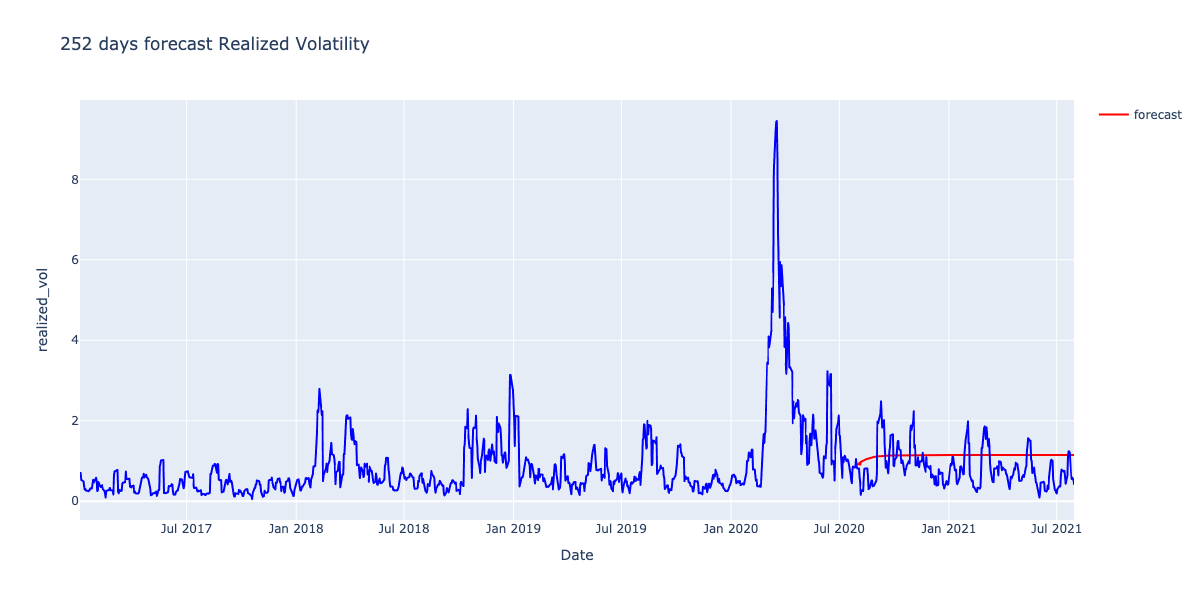

In [167]:
model = arch_model(X_train.returns, mean='zero', vol='ARCH', p=p).fit(disp='off')
print(arch.summary())
forecast= model.forecast(horizon= n)
frcts_values= np.sqrt(forecast.variance.iloc[-1:].melt().drop(columns="variable"))
frcts_values.index= y_test.index
plot_forecat("252 days forecast")

### ARCH Rolling Forecats

In [168]:
frcts_values= rolling_forecast(y_test, "ARCH", p=1 )
rmse =  eval_rmse(y_test, frcts_values)
df_resuts= pd.DataFrame({ "model" :  ["arch_rolling"] , "results" : [rmse]}, index= [0] )
df_resuts

,model,results
0,arch_rolling,0.094669


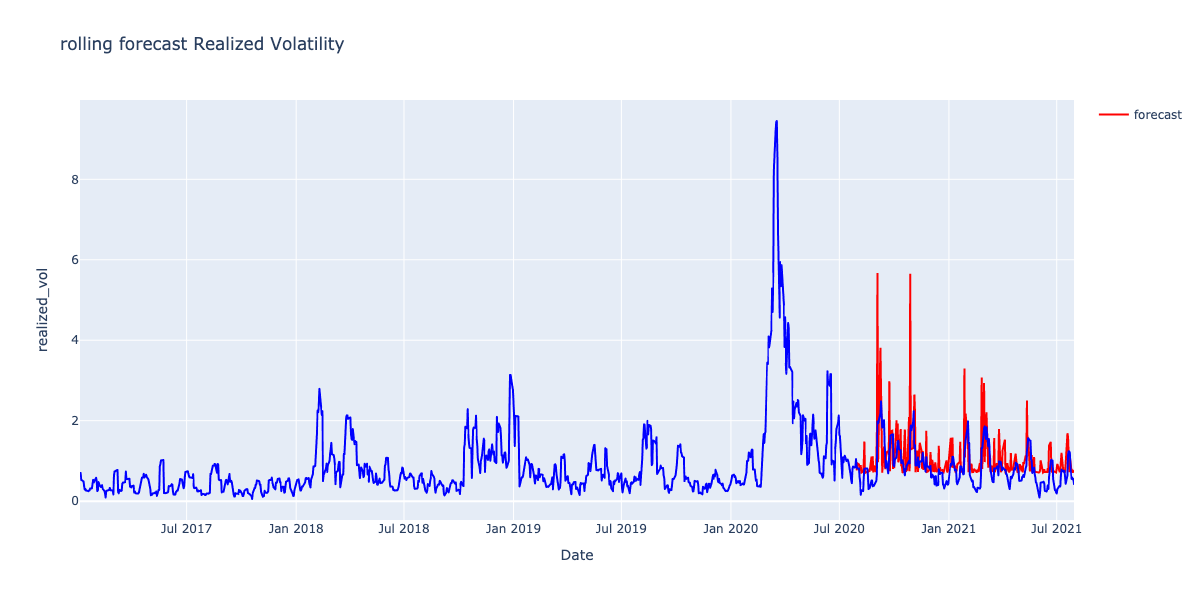

In [169]:
plot_forecat("rolling forecast")

## Generalised conditional hetroskadestic model (GARCH models)

it is possible to model higher order ARCH models. However, these models are difficult to estimate for higher orders of lag since they often produce negative estimates of the $\alpha s$.

To solve this problem, people have turned to the GARCH model (Bollerslev 1986).

Essentially, the GARCH model turns the AR process of the ARCH model into an ARMA process by adding in a moving average process. In the GARCH model, the conditional disturbance variance is now

$\sigma^2_t = \alpha_0 + \alpha_1\epsilon^2_{t-1} + \cdots + \alpha_p\epsilon^ 2_{t-p} + \gamma_1\sigma^2_{t-1} + \gamma_2\sigma^2_{t-2} + \cdots + \gamma_q\sigma^2_{t-q}$

$\sigma^2_t = \alpha_0 + \sum_{j=1}^{p} \alpha_j \epsilon^2_{t-j} + \sum_{k=1}^{q} \gamma_k \sigma^2_{t-k} \qquad\qquad\qquad(1)$


### GARCH Model

selecting the ARMA order is using Bayesian information criteria we can loop the p and q order and selection the model with minimum bic value

### GARCH Next 252 Days Forecats

In [170]:
bic_garch = []
for p in range(1, 5):
    for q in range(1, 5):
        model = arch_model(X_train.returns, mean='zero',vol='GARCH', p=p, o=0, q=q).fit(disp='off')
        bic_garch.append(model.bic)
        if model.bic == np.min(bic_garch):
            best_param = p, q
            print(best_param)                   
model = arch_model(X_train.returns, mean='constant', vol='GARCH',p=best_param[0], o=0, q=best_param[1]).fit(disp='off')
print(model.summary())

forecast= model.forecast(horizon= n)
frcts_values= np.sqrt(forecast.variance.iloc[-1:].melt().drop(columns="variable"))
frcts_values.index= y_test.index

(1, 1)
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -3297.16
Distribution:                  Normal   AIC:                           6602.33
Method:            Maximum Likelihood   BIC:                           6625.87
                                        No. Observations:                 2657
Date:                Mon, Mar 06 2023   Df Residuals:                     2656
Time:                        13:50:59   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.0830  1.388e-02      5.982  2.200e-09 [5

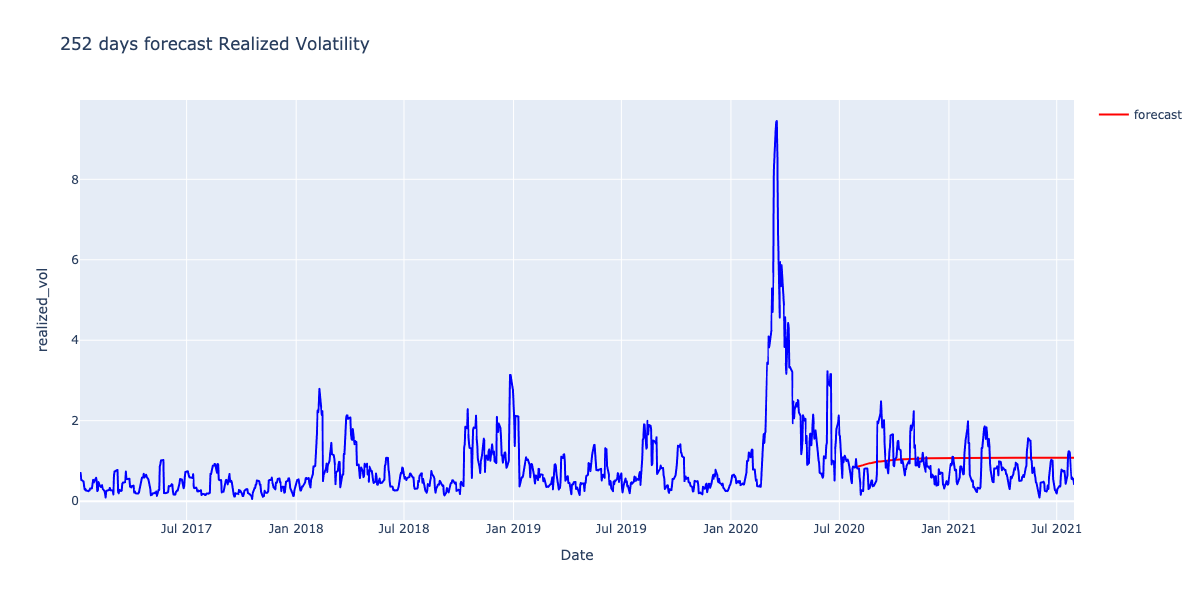

In [171]:
plot_forecat("252 days forecast")

### Garch Rolling Forecast

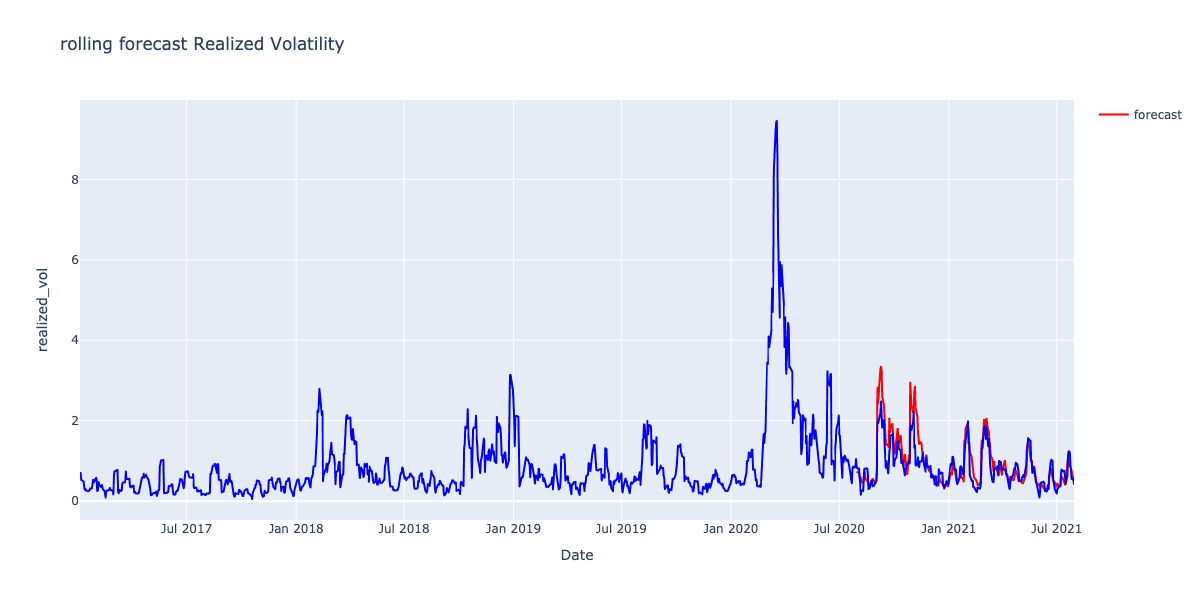

In [172]:
frcts_values= rolling_forecast(y_test, "GARCH", p=1, q=1 )
rmse =  eval_rmse(y_test, frcts_values)
df_resuts.loc[len(df_resuts.index)]= { "model" :  "garch_rolling" , "results" : rmse}
plot_forecat("rolling forecast")

## GJR-GARCH

The GJR-GARCH model performs well in modeling the asymmetric effects of announcements in the way that bad news has a larger impact than good news. In other words, in the presence of asymmetry, the distribution of losses has a fatter tail than the distribution of gains. The equation of the model includes one more parameter, γ , and it takes the following form:

$\sigma_{t}^{2} = \omega + \sum_{k=1}^{q} \alpha_{k}r_{t-k}^{2} + \gamma(r_{t-k}<0)\times\gamma_{t-k}^{2} + \sum_{k=1}^{p} \beta_{k}\sigma_{t-k}^{2} $

where $\gamma$ controls for the asymmetry of the announcements and if:

$\gamma=0$, the response to the past shock is the same.
$\gamma>0$, the response to the past negative shock is stronger than a positive one.
$\gamma<0$, the response to the past positive shock is stronger than a negative one.

### GJR-GARCH Roling Forecast

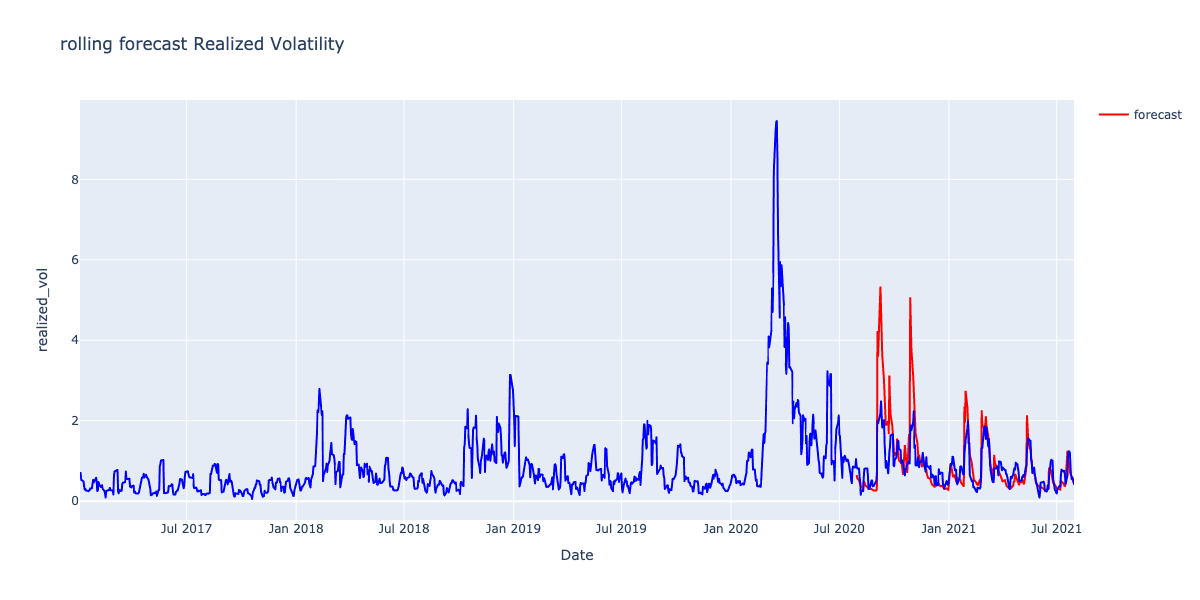

            model   results
0    arch_rolling  0.094669
1   garch_rolling  0.088160
2  gjr-garch_r...  0.088175


In [173]:
frcts_values= rolling_forecast(y_test, vol= "None", p=1, q=1, o=1 )
rmse =  eval_rmse(y_test, frcts_values)
df_resuts.loc[len(df_resuts.index)]= { "model" :  "gjr-garch_rolling" , "results" : rmse}
plot_forecat("rolling forecast")
print(df_resuts)

## EGARCH

The EGARCH model, proposed by Nelson (1991), is another tool for controlling for the effect of asymmetric announcements. Additionally, it is specified in logarithmic form, so there is no need to add restrictions to avoid negative volatility:

$\log(\sigma_{t}^{2}) = \omega + \sum_{k=1}^{p} \beta_{k}\log(\sigma_{t-k}^{2}) + \sum_{k=1}^{q} \alpha_{i}r_{k-1}\frac{\sigma_{t-k}^{2}}{\sigma_{t-1}^{2}} + \sum_{k=1}^{q} \gamma_{k}\frac{|r_{t-k}|}{\sigma_{t-k}}$

The main difference in the EGARCH equation is that logarithm is taken of the variance on the left-hand side of the equation. This indicates the leverage effect, meaning that there exists a negative correlation between past asset returns and volatility. If $\gamma<0$, it implies leverage effect, and if $\gamma\neq0$, that shows asymmetry in volatility.

### E_GARCH Rolling Foreacst

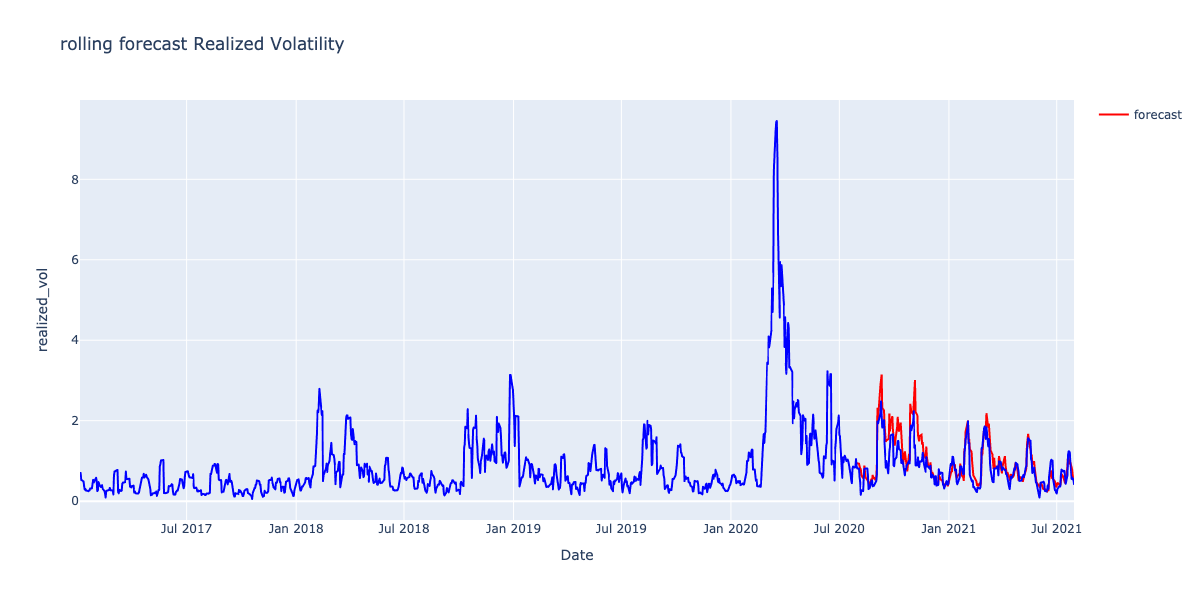

            model   results
0    arch_rolling  0.094669
1   garch_rolling  0.088160
2  gjr-garch_r...  0.088175
3  Egarch_rolling  0.090970


In [174]:
frcts_values= rolling_forecast(y_test, vol= "EGARCH", p=1, q=1)
rmse =  eval_rmse(y_test, frcts_values)
df_resuts.loc[len(df_resuts.index)]= { "model" :  "Egarch_rolling" , "results" : rmse}
plot_forecat("rolling forecast")
print(df_resuts)

## Results Table

In [175]:
df_resuts.sort_values("results")

,model,results
1,garch_rolling,0.088160
2,gjr-garch_r...,0.088175
3,Egarch_rolling,0.090970
0,arch_rolling,0.094669


# Conclusion:
* We estimated volatility using 4 different time series model. 
* We find that GARCH model out of all 4 performs the best for rolling forecast.